## ------------------------------Model comparisons between all models------------------------------

In [60]:
import pickle 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pandas as pd
from pylab import rcParams
rcParams['figure.figsize'] = 8.5,6
from inspect import signature
import scikitplot 
from yellowbrick.classifier import PrecisionRecallCurve
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


##  ----------------------------------------------Read all models----------------------------------------

In [61]:
## read test data
with open('test_data.pkl', 'rb') as f:
      X_te, y_te = pickle.load(f)
        
with open('test_data2.pkl', 'rb') as f:
      X_te2, y_te2 = pickle.load(f)

In [62]:
## read best count vectorization models
filename1 = ['knn_model/knn_count.pkl','svc_model/svc_count.pkl','bayes_model/MNB1.pkl','RF_model/RF_count.pkl']
best_count_models = []
for fn in filename1:
    with open(fn,'rb') as f:
        best_count_models.append(pickle.load(f))

In [63]:
## read best tfid bectorization models
filename2 = ['knn_model/knn_tfid.pkl','svc_model/svc_tfid.pkl','bayes_model/BNB2.pkl','RF_model/RF_tfid.pkl']
best_tfid_models = []
for fn in filename2:
    with open(fn,'rb') as f:
        best_tfid_models.append(pickle.load(f))

### ------------------------------Define functions for model comparisons and plots----------------------------------------

In [92]:
def save_f1_score(models,x_te,y_te,word2vec):
    """Calculate f1 scores for different models
    """
    f_score = dict()
    labels = ['KNN','SVC',"Bayes","RandomForest"]
    for l,m in zip(labels,models):
        y_pred = m.predict(x_te)
        f_score[l] = f1_score(y_te,y_pred,labels=np.unique(y_pred))
    df = pd.DataFrame.from_dict(f_score,orient='index',columns =[word2vec])
    return df

In [93]:
def calculate_roc(models,x_te,y_te,word2vec):
    """Calculate FPR,TPR,ROC_ACU
    parameters:
        - models(list):all best models for specific word2vec methods
        - x_te(array_like):test data
        - y_te(arraye_like):test labels
        
    Return:
        fpr(list): false positive rate
        tpr(list): true positive rate
        roc_auc(list): area under roc curve
        precision(list): precision
        recall(list): recall
        pr_auc(list): area under precision recall curve
        confusion_matrix
    
    """
    fpr= dict()
    tpr = dict()
    roc_auc = dict()
    precision = dict()
    recall = dict()
    pr_auc=dict()
    labels = ['KNN','SVC',"Bayes",'RandomForest']
    f, axes = plt.subplots(1,4,figsize=(12,12))
    for i,m in enumerate(models):
        y_score = m.predict_proba(x_te)
        y_pred = m.predict(x_te)
        fpr[i], tpr[i], _ = roc_curve(y_te, y_score[:,1],pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])
        precision[i], recall[i], _ = precision_recall_curve(y_te, y_score[:,1],pos_label=1)
        pr_auc[i] = auc(recall[i], precision[i])
        
        plt.subplots_adjust(hspace = .1)
        mtx = confusion_matrix(y_te, y_pred)
        g = sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", square=True, cbar=False,ax=axes[i])  
        g.set_ylabel('true label')
        g.set_xlabel('predicted label')
        g.set_title(labels[i]+ " & "+word2vec )
    f.tight_layout() 
    filename = word2vec+" confusion_matrix.png"
    f.savefig('figs/'+filename)
    return fpr,tpr,roc_auc,precision,recall,pr_auc

In [94]:
def plot_roc(fpr,tpr,roc_auc,word2vec):
    """Plot Roc Curve
    parameters:
        fpr(list): false positive rate
        tpr(list): true positive rate
        roc_auc(list): area under roc curve
        word2vec(str): specify vectorization method
    
    """
    colors = ['red', 'darkorange', 'blue','grey']
    labels = ['KNN','SVC',"Bayes",'RandomForest']
    for i, color in enumerate(colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2.5,linestyle='--',
                 label='ROC curve of {0} (area = {1:0.5})'
                 ''.format(labels[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=1.2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE for '+word2vec)
    plt.legend(loc="lower right")
    filename = word2vec+"_roc"+".png"
    plt.savefig('figs/' + filename)
    plt.show()

In [95]:
def plot_precision_recall(precision,recall,pr_auc,word2vec):
    """Plot Roc Curve
    parameters:
        fpr(list): false positive rate
        tpr(list): true positive rate
        roc_auc(list): area under roc curve
        word2vec(str): specify vectorization method
    
    """
    colors =['red', 'darkorange', 'blue','grey']
    labels = ['KNN','SVC',"Bayes",'RandomForest']
    for i, color in enumerate(colors):
        plt.plot(recall[i],  precision[i],color=color, lw=2.5,linestyle='--',
                 label='Precision Recall curve of {0} (area = {1:0.5})'
                 ''.format(labels[i], pr_auc[i]))
        
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    
    plt.title('Precsion Recall CURVE for '+word2vec)
    plt.legend(loc="lower right")
    filename = word2vec+"_pr"+".png"
    plt.savefig('figs/' + filename)
    plt.show()

## -----------------------------------------Counter vectorization----------------------------------------

In [96]:
## report f1 score
df1 = save_f1_score(best_count_models,X_te,y_te,"CountVectorizer")
df1

,CountVectorizer
KNN,0.970667
SVC,0.987084
Bayes,0.985507
RandomForest,0.983784


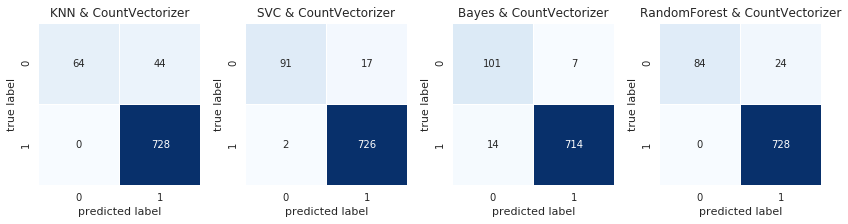

In [97]:
## calculate for counter verctorization
fpr1,tpr1,roc_auc1,precision1,recall1,pr_auc1 = calculate_roc(best_count_models, X_te,y_te,"CountVectorizer")

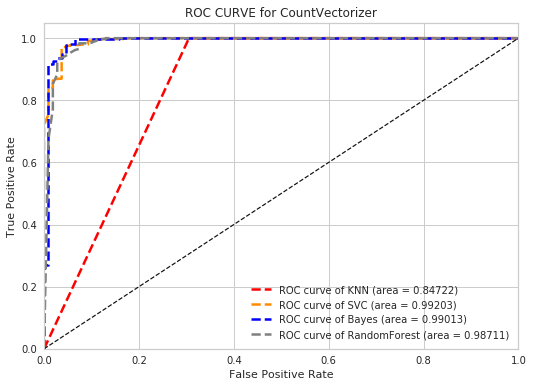

In [98]:
## plot roc curve for counter verctorization
plot_roc(fpr1,tpr1,roc_auc1,"CountVectorizer")

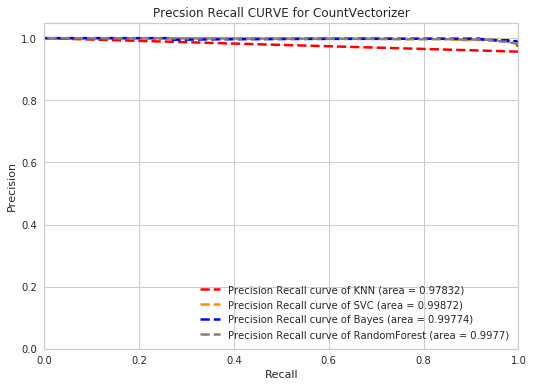

In [87]:
plot_precision_recall(precision1,recall1,pr_auc1,"CountVectorizer")

## ----------------------------------------TFID vectorization--------------------------------------------

In [88]:
df2 = save_f1_score(best_tfid_models,X_te2,y_te2,"TfidVectorizer")
df2

,TfidVectorizer
KNN,0.947356
SVC,0.979196
Bayes,0.974187
RandomForest,0.976323


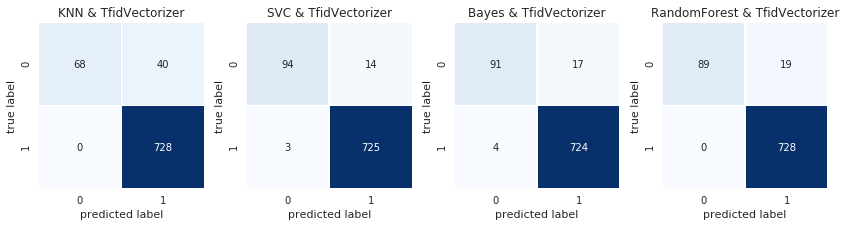

In [89]:
## calculate for tfid verctorization
fpr2,tpr2,roc_auc2,precision2,recall2,pr_auc2 = calculate_roc(best_tfid_models, X_te2,y_te2,"TfidVectorizer")

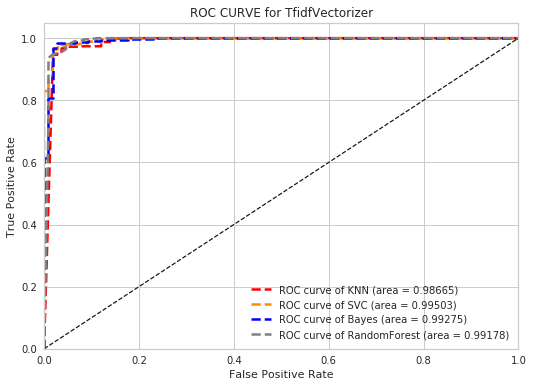

In [90]:
## plot for tfid verctorization
plot_roc(fpr2,tpr2,roc_auc2, 'TfidfVectorizer')

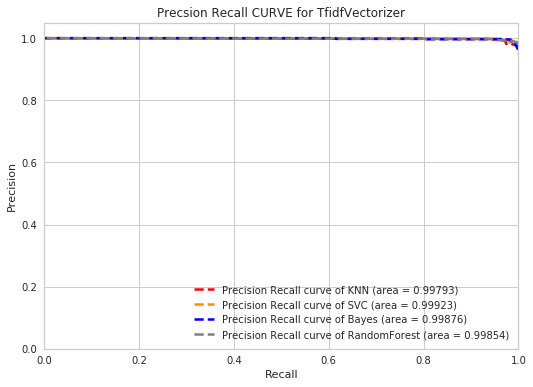

In [91]:
plot_precision_recall(precision2,recall2,pr_auc2, 'TfidfVectorizer')